In [23]:
import matplotlib.pyplot as plt
import numpy as np

[[0.148 0.7   0.01  0.33  0.13 ]
 [0.09  0.25  0.006 0.37  0.17 ]]


([<matplotlib.axis.XTick at 0x7f7575662700>,
 [Text(0.25, 0, 'LunchBreak'),
  Text(1.25, 0, 'StaplerSupply'),
  Text(2.25, 0, 'ElevatorTour'),
  Text(3.25, 0, 'MovieMessenger'),
  Text(4.25, 0, 'HalloweenList')])

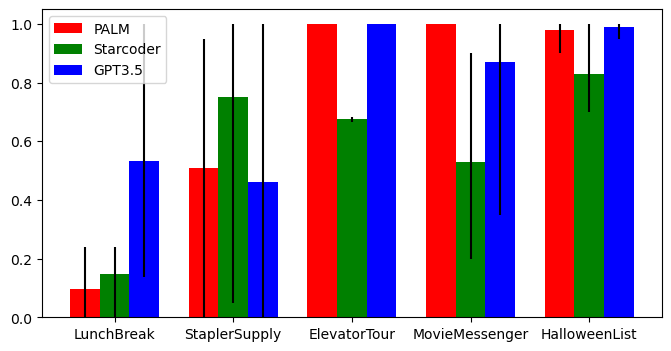

In [51]:
tasks_len = 5
palm = np.array([0.095, 0.510, 1.000, 1.000, 0.980])
starcoder = [0.148, 0.750, 0.677, 0.530, 0.830]
gpt = [0.532, 0.460, 1.000, 0.870, 0.990]

barWidth = 0.25
br1 = np.arange(tasks_len)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


palm_err = abs(np.array([[0, 0, 1, 1, 0.9], [0.238, 0.950, 1, 1, 1]]) - palm)
starcoder_err = abs(np.array([[0, 0.05, 0.667, 0.2, 0.7], [0.238, 1, 0.683, 0.9, 1]]) - starcoder)
gpt_err = abs(np.array([[0.137, 0, 1, 0.35, 0.95], [1, 1, 1, 1, 1]]) - gpt)

print(starcoder_err)
plt.figure(figsize=[8,4])
plt.bar(br1,palm, color ='r', width = barWidth, yerr=palm_err)
plt.bar(br2,starcoder, color ='g',width = barWidth, yerr=starcoder_err)
plt.bar(br3,gpt, color ='b',width = barWidth, yerr=gpt_err)

plt.legend(["PALM", "Starcoder", "GPT3.5"])
plt.xticks([r + barWidth for r in range(tasks_len)],
        ['LunchBreak', 'StaplerSupply', 'ElevatorTour', 'MovieMessenger', 'HalloweenList'])